# Proyecto Integrador 2: Tienda en línea de alimentos

# Contents
* [1. Introducción y objetivos.](#objetivo)

* [2. Preparar los datos para el análisis.](#preparacion)

* [3. Estudiar y comprobar los datos.](#estudiar)

* [4. Estudiar el embudo de eventos.](#embudo)

* [5. Estudiar los resultados del experimento.](#resultados)

* [6. Conclusiones generales.](#conclusiones)




# 1. Introducción y objetivos






El objetivo de este proyecto es investigar el comportamiento del usuario para la aplicación de la empresa que vende productos alimenticios.

Primero, estudiaremos el embudo de ventas. Descubriremos cómo los usuarios y las usuarias llegan a la etapa de compra. ¿Cuántos usuarios o usuarias realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observaremos los resultados de un test A/A/B. Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios y las usuarias piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.


Los usuarios se dividirán en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubriremos qué conjunto de fuentes produce mejores resultados.


El hecho de crear dos grupos A tiene ciertas ventajas. Por ejemplo podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados.




<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Buen inicio con tabla de contenidos e introducción.
</div>

# 2. Preparar los datos para el análisis

In [49]:
#Importacion de las librerías
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from scipy import stats as st
import math as mth
from scipy.stats import ttest_ind



<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Muy bien, siempre recuerda usar una celda independiente para importar las librerías, especialmente en proyectos grandes como este, eso nos ayuda a mantener el código ordenado y limpio.
</div>

In [50]:
# Importación del dataset
df=pd.read_csv('/datasets/logs_exp_us.csv',sep='\t')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


* Podemos ver que el dataset contiene 244,125 registros y 4 columnas:
1. EventName: nombre del evento.
2. DeviceIDHash: identificador de usuario unívoco.
3. EventTimestamp: hora del evento.
4. ExpId: número de experimento: 246 y 247 son los grupos de control, 248 es el grupo de prueba.

* El dataframe no contiene valores ausentes.
* Realizaremos el cambio en el nombre de las columnas y el tipo de datos que corresponde


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Buen uso de las funciones de pandas para explorar los datos.
</div>

In [51]:
#Cambiar el nombre de las columnas
df.rename(columns={'EventName':'event_name','DeviceIDHash':'device_id_hash','EventTimestamp':'event_time','ExpId':'exp_id'},inplace=True)
#Cambio del tipo de dato
df['event_time']=df['event_time'].astype('datetime64[s]')
#Agregar una columna con la fecha 
df['date']=df['event_time'].astype('datetime64[D]')
#Agregar una columna con la hora
df['hour']=df['event_time'].dt.time

#Informacion del dataframe
df.info()
print( )
# Primeras 5 filas
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      244126 non-null  object        
 1   device_id_hash  244126 non-null  int64         
 2   event_time      244126 non-null  datetime64[ns]
 3   exp_id          244126 non-null  int64         
 4   date            244126 non-null  datetime64[ns]
 5   hour            244126 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB



,event_name,device_id_hash,event_time,exp_id,date,hour
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42



<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Limpiaste correctamente estas tablas.
</div>


A continuacion validaremos si existen valores duplicados

In [52]:
#Suma de valores duplicados
df.duplicated().sum()

413

Encontramos 413 valores duplicados, asi que identificaremos por id cuantas veces se repite.

In [53]:
#Conteo de los id
duplicados=df[df.duplicated()]
duplicados['device_id_hash'].value_counts()

3610536745613892312    41
3473691793382022823    23
4980045449118619005    11
6932517045703054087     9
636437379427729086      7
                       ..
5169064326562477189     1
54903596035630984       1
656563515679158310      1
1228115547394833641     1
366093607806007780      1
Name: device_id_hash, Length: 237, dtype: int64

* Dado que este dataframe se encuentra todas los eventos que realizaron los usuarios al momento de navegar en la tienda online, es normal que se cuenten con valores repetidos, a continuacion veremos un ejemplo para el primer usuario.

In [54]:
y=duplicados.query('device_id_hash == 3610536745613892312').groupby(['date','event_name']).agg({'device_id_hash':'count'}).sort_values(by='date',ascending=True)
y

,,device_id_hash
date,event_name,
2019-08-03,PaymentScreenSuccessful,16
2019-08-04,PaymentScreenSuccessful,23
2019-08-07,PaymentScreenSuccessful,2


* Como podemos observar este usuario ha ingresado a la tienda en linea desde el 3 de agosto del 2019 y ha registrado 16 eventos ese día, y asi sucesivamente durante el 4 y 7 de agosto. En este caso podemos ver que este usuario ha realizado varias compras satisfactoriamente.

* Dado que no tenemos valores duplicados, realizaremos una validación mas para asegurar que los mismos usuarios no se encuentren repetidos en los grupo de experimentos 246,247 del grupo de control y 248 del grupo de prueba.

In [55]:
#Validacion 
validacion=df.pivot_table(index=['device_id_hash'],columns='exp_id',values='event_name',aggfunc='count')
validacion.tail(20)


exp_id,246,247,248
device_id_hash,,,
9202927726357731300,NaN,10.0,NaN
9203989356000728141,117.0,NaN,NaN
9204534675405261953,21.0,NaN,NaN
9206002508877262744,NaN,81.0,NaN
9206914539894781010,15.0,NaN,NaN
9210082518034880206,NaN,NaN,33.0
9211196294399965012,NaN,NaN,43.0
9212377414136562136,NaN,NaN,7.0
9212420551954885212,NaN,NaN,84.0


* Podemos ver en las ultimas 20 filas que los usuarios no se repiten entre los grupos de control y de prueba. Entonces comenzaremos con el anâlisis de los datos.


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Bien.
</div>

# 3. Estudiar y comprobar los datos

**3.1 ¿Cuántos eventos hay en los registros?**

In [56]:
print('Numero de eventos:',len(df['event_name']))

Numero de eventos: 244126


**3.2 ¿Cuántos usuarios y usuarias hay en los registros?**

In [57]:
print('Numero de usuarios en los registros:',df['device_id_hash'].nunique())

Numero de usuarios en los registros: 7551


**3.3 ¿Cuál es el promedio de eventos por usuario?**

In [58]:
print('Promedio de eventos por usuario',round(len(df)/df['device_id_hash'].nunique()))


Promedio de eventos por usuario 32


**3.4 ¿Qué periodo de tiempo cubren los datos?**

In [59]:
print('Fecha minima:',df['event_time'].min())
print('Fecha maxima:',df['event_time'].max())

Fecha minima: 2019-07-25 04:43:36
Fecha maxima: 2019-08-07 21:15:17


* El periodo de datos cubren desde el 25 de julio del 2019 hasta el 7 de agosto del 2019. Es decir tenemos informacion de los registros de menos de un mes.


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Usaste los datos correctamente para responder las preguntas.
</div>

Realizaremos un gráfico de barras para observar la frecuencia de los periodos que mas se repiten, esta grafica nos ayudara a visualizar en que dia los usuarios ingresaron mas veces o menos veces al sitio web.

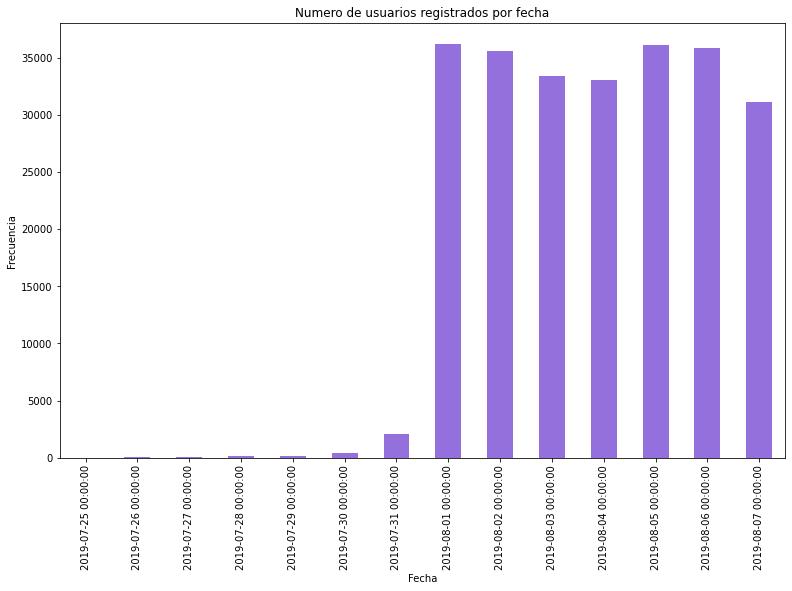

In [60]:
#Grafico en barras 
df.groupby('date')['device_id_hash'].count().plot(kind='bar',figsize=(13,8),color='mediumpurple')
plt.title('Numero de usuarios registrados por fecha')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.show()


<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Cuando se grafican datos que no son distribuciones con histogramas se debe tener cuidado, las fechas podrían no salir ordenadas o los datos se podrían agrupar en bins no deseados. Lo mejor sería realizar una gráfica de barras donde el eje X sean las fechas y el Y los conteos de eventos por día (que puedes obtener con un groupby). Te daría una gráfica parecida, pero puedes tener mayor control sobre los datos que graficas.
</div>

<div class="alert alert-block alert-info">
<b>Actualizado, gracias</b> <a class="tocSkip"></a>
</div>

* El grafico indica que a partir del 1 de agosto del 2019 en adelante tenemos mayores numeros de eventos, entre un rango de 30,000 a 36,000.
* Esto nos indica que desde la fecha minima del 25 de julio del 2019 hasta el fin de mes son mīnimos los eventos registrados, pasando de 2000 eventos a mas de 35.0000 de un dīa al otro.
* Esta observación nos hace sospechar que a lo mejor el sistema no extrajo la data completa de los eventos registrados en el mes de julio y se perdió esa información, o algún fallo técnico en los serividores que no permitieron rastrear compeltamente las actividades de los usuarios.
* Para evitar que este problema afecte el sesgo general de la data, tomaremos solo la información que tenemos completa que sería desde el 1 al 7 de agosto.

In [61]:
#Medicion de la exclusion de los datos incompletos
periodo=df.groupby(['date']).agg({'event_name':'count'}).sort_values(by='date',ascending=False)
data_completa=df.query('date > "2019-07-31"')
print('Los datos completos son:',len(data_completa))

data_incompleta=df.query('date <= "2019-07-31"')
print('Los datos incompletos son:',len(data_incompleta))

print('Porcentaje de datos excluidos:',round(100*len(data_incompleta)/len(data_completa),2))     
      
print('Porcentaje de usuarios unicos excluidos:',round(100*(data_incompleta['device_id_hash'].nunique()/len(data_completa)),2))


Los datos completos son: 241298
Los datos incompletos son: 2828
Porcentaje de datos excluidos: 1.17
Porcentaje de usuarios unicos excluidos: 0.6


In [62]:
# Aplicacion del periodo de datos completo 
df=df.query('date != ("2019-07-25","2019-07-26","2019-07-27","2019-07-28","2019-07-29","2019-07-30","2019-07-31")')
#Validacion
df1=df.groupby(['date']).agg({'event_name':'count'}).sort_values(by='date',ascending=False)
df1

,event_name
date,
2019-08-07,31144
2019-08-06,35822
2019-08-05,36113
2019-08-04,33033
2019-08-03,33351
2019-08-02,35606
2019-08-01,36229


Finalmente nos aseguraremos de tener usuarios en los 3 grupos experimentales.

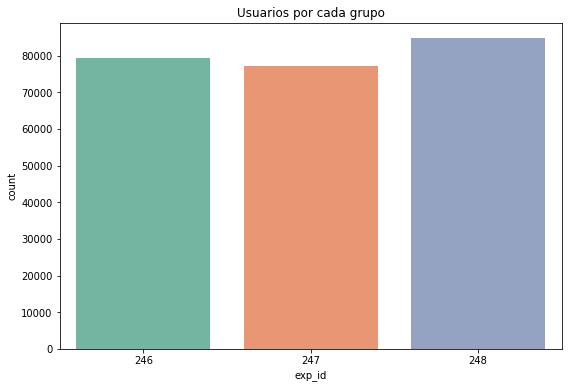

In [63]:
plt.figure(figsize=(9, 6))
sns.set_palette("Set2")
sns.countplot(data=df,x='exp_id').set(title='Usuarios por cada grupo')
plt.show()


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Buen trabajo. Tus gráficas tienen títulos y nombres en los ejes.
</div>

* El numero de usuarios estan muy parecidos entre los 3 grupos experimentales, aproximadamente entre 80.000 y 83.000.

# 4. Estudiar el embudo de eventos

**4.1 Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.**

In [64]:
eventos=df.pivot_table(index='event_name',values='exp_id',aggfunc='count').sort_values(by='exp_id',ascending=False)
eventos

,exp_id
event_name,
MainScreenAppear,117431
OffersScreenAppear,46350
CartScreenAppear,42365
PaymentScreenSuccessful,34113
Tutorial,1039


* Tenemos 5 tipos de eventos registrados en el sitio web. 
* Ciertamente el MainScreenAppear corresponde a que tenga más registros porque es la página de inicio y por la primera que deben pasar.
* Podemos ver el numero de registros para pasar por el recorrido o tutorial virtual es el menor.

**4.2 Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.**

In [65]:
eventos_id=df.pivot_table(index='event_name',values='device_id_hash',aggfunc='nunique').sort_values(by='device_id_hash',ascending=False)
eventos_id['usuarios_unicos_totales']=df['device_id_hash'].nunique()
eventos_id['proporcion']=eventos_id['device_id_hash']/ eventos_id['usuarios_unicos_totales']
eventos_id

,device_id_hash,usuarios_unicos_totales,proporcion
event_name,,,
MainScreenAppear,7419,7534,0.984736
OffersScreenAppear,4593,7534,0.609636
CartScreenAppear,3734,7534,0.495620
PaymentScreenSuccessful,3539,7534,0.469737
Tutorial,840,7534,0.111495


* El 98% de los usuarios que ingresan al sitio web pasan por el MainScreenAppear.
* Desde que ingresan los usuarios a ver una oferta y quienes realizan el pago hay una brecha del 14% menos, eso nos indica que pueden ser que esten comparando precios, ofertas y productos con otro sitio web, o simplemente desistieron de seguir viendo ofertas.
* Solo el 11% de los usuarios pasan por el tutorial.

**4.3 ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.**

* El orden de las acciones se deriva desde que el usuario a traves de publicidad organica o pagada ingresa a nuestro sitio web y es dirigido a la pagina princial o conocido como "MainScreenAppear",después la lógica es que ingrese a la sección de busqueda de ofertas de algún producto que se encuentre en promoción el evento que lo caracteriza es "OffersScreenAppear", si el usuario encontró el producto y oferta que necesitaba lo ingresa a su carrito de compras que es "CartScreenAppear", para finalmente dirigirse a la sección de pagos y completar su compra en "PaymentScreenSuccessful". 

* Todos estos eventos son parte de una sola secuencia y necesarios para tomar accion desde que visita la pagina hasta que completa su orden de compra, el evento de "Tutorial" no lo tomamos en cuenta en el orden de la secuencia porque no es un paso obligatorio y necesario que debe completar para poder ver ofertas o hacer el pago, ya que tiene el botón de saltar el tutorial.


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Buen comentario.
</div>

Graficaremos un embudo con los 4 tipos de eventos identificados para observar en que etapa o paso es donde perdemos mas usuarios y conocer el porcentaje de usuarios que pasan de un evento a otro.

In [66]:
#Embudo
funnel=df.query('event_name!= "Tutorial"').groupby(['event_name']).agg({'device_id_hash':'nunique'}).sort_values(by='device_id_hash',ascending=False).reset_index()
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['device_id_hash']))
fig.show()

* Para la secuencia de eventos en Mainscreen que tiene 7419 usuarios , solo un 62% de ellos pasan a Offerscreen. Es mas de la mitad de los usuarios que quizá no les gusta el diseńo de la página principal o no es llamativo para que invite al usuario a seguir navegando en el sitio web. Es la etapa en la que se pierde el mayor numero de usuarios.
* Una vez que los 4593 usuarios estan en la pagina de ofertas, el 81% de ellos agregan los productos a su carrito de compras, en esta estapa las ofertas, precios,productos juegan un importante rol porque si les convence se deciden por incluirlo en su lista de compras. 
* Finalmente el 95% de los usuarios que añadieron los productos realizan el pago y la orden de compra satisfactoriamente, podriamos decir que ese 5% faltante decidió abandonar la compra o simplemente se pudo olvidar de pagar. 
* El embudo nos indica que de los 7419 usuarios que ingresan al sitio web, menos de la mitad es decir el 47% logran hacer una compra, esto nos indica que el nivel de conversión esta muy por debajo y son pocos usuarios quienes pasan por todas las etapas.


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Buen uso de plotly para graficar el funnel. Las gráficas interactivas son muy buenas y siempre son agradables de usar.
</div>

# 5. Estudiar los resultados del experimento

**5.1 ¿Cuántos usuarios y usuarias hay en cada grupo?**

In [67]:
user_exp=df.groupby('exp_id').agg({'device_id_hash':'nunique'})
user_exp

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


* Existen aproximadamente entre 2400 a 2500 usuarios unicos en cada grupo.

**5.2 Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.**

Empezaremos a crear una tabla que nos indique el numero de usuarios unicos, a que experimento pertenecen y en otra columna la conversion del usuario,pondremos 1 si hizo una compra y 0 si no realizo ninguna compra.

In [68]:
# Eliminacion de duplicados entre el id y el experimento.
conversion=df[['device_id_hash','exp_id']].drop_duplicates()
conversion.head()

,device_id_hash,exp_id
2828,3737462046622621720,246
2832,1433840883824088890,247
2833,4899590676214355127,247
2840,1182179323890311443,246
2844,4613461174774205834,248


In [69]:
len(conversion)

7534

* Tenemos 7,534 usuarios unicos entre los 3 grupos

Continuaremos creando otro dataframe en el que filtraremos el evento en el que si realizaron una compra junto con los usuarios unicos para identificar si fueron parte de la conversion.

In [70]:
#Dataframe, conversion usuarios unicos
master_table= pd.DataFrame(data={
    
    'device_id_hash': df[df['event_name']== 'PaymentScreenSuccessful']['device_id_hash'].unique(),
    'converted': 1 })
master_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3539 entries, 0 to 3538
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   device_id_hash  3539 non-null   int64
 1   converted       3539 non-null   int64
dtypes: int64(2)
memory usage: 55.4 KB


Ahora que tenemos identificado los usuarios unicos, y en la otra tabla la conversion realizaremos una combinación.

In [71]:
#Merge
df_merge=conversion.merge(master_table,on='device_id_hash',how='left')
df_merge.head()

,device_id_hash,exp_id,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,NaN
2,4899590676214355127,247,1.0
3,1182179323890311443,246,NaN
4,4613461174774205834,248,1.0


Vemos que tenemos valores como NaN, y esos usuarios entonces no realizaron ningun compra. Por lo que rellenaremos los valores ausentes con 0.

In [72]:
# Relleno de los valores ausentes por 0
df_merge['converted']=df_merge['converted'].fillna(0)
df_merge.head()

,device_id_hash,exp_id,converted
0,3737462046622621720,246,1.0
1,1433840883824088890,247,0.0
2,4899590676214355127,247,1.0
3,1182179323890311443,246,0.0
4,4613461174774205834,248,1.0


A continuacion necesitamos tener las proporciones de exito o conversion de los 2 grupos de control que nos interesa, como tambien conocer el numero de usuarios unicos en cada grupo.

In [73]:
#Numero de usuarios convertidos grupo 246 y 247

converted_users_246=df_merge.query('exp_id == 246 and converted==1')['converted'].count()
converted_users_247=df_merge.query('exp_id == 247 and converted ==1')['converted'].count()

#Numero de usuarios en el grupo 246 y 247


users_246=df_merge.query('exp_id == 246')['device_id_hash'].count()
users_247=df_merge.query('exp_id == 247')['device_id_hash'].count()


print('Numero de usuarios unicos convertidos 246:',converted_users_246)
print('Numero de usuarios unicos convertidos 247:',converted_users_247)


print('Numero de usuarios unicos grupo 246:',users_246)
print('Numero de usuarios unicos grupo 247:',users_247)


Numero de usuarios unicos convertidos 246: 1200
Numero de usuarios unicos convertidos 247: 1158
Numero de usuarios unicos grupo 246: 2484
Numero de usuarios unicos grupo 247: 2513


Una vez contamos con los datos que nos interesan para cada grupo, procederemos con la declaración de las hipótesis.

Hipotesis nula: Las porporciones de conversion en los 2 grupos de control son iguales. 

Hipotesis alternativa: Existe diferencia entre las proporciones de conversion entre los 2 grupos de control.

In [74]:
#Prueba de proporciones 

alpha=0.1 #nivel de significacion

success=np.array([1200,1158])
trials=np.array([2484,2513])

#proporcion de exito en el grupo 246

p_246= success[0]/trials[0]

#proporcion de exito en el grupo 247

p_247= success[1]/trials[1]

p_combined=(success[0]+success[1])/(trials[0]+trials[1])

p_difference= p_246-p_247
 # Calculemos la estadística en términos de desviaciones estándar de la distribución normal estándar:

z_value = p_difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# Establecemos la distribución normal estándar (media 0, desviación estándar 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes") 

p-value:  0.11456679313141849
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


* Dado que el valor p es mayor al nivel de signficancia, no hay evidencia estadistica para rechazar la hipotesis de que las proporciones de exito en los 2 grupos son igiales. En resumen no existe una diferencia significativa entre los dos grupos de control.


<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Realizaste correctamente la prueba de hipótesis, podrías escribir la hipótesis nula y la alternativa para que quede más claro el análisis.
</div>

<div class="alert alert-block alert-info">
<b>Actualizado, gracias</b> <a class="tocSkip"></a>
</div>

**5.3 Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa.**

Realizaremos una fórmula para encontrar si hay una diferencia estadisticamente significativa entre la cantidad de usuarios del grupo 246 y 247 para cada tipo de evento.

In [75]:
#Creacion de la funcion prueba
def t_test9(data,group1,group2,event,group_col='exp_id',converted_column='converted'):
    
    conversion= df[['device_id_hash',group_col]].drop_duplicates()
    
    master_table= pd.DataFrame(data={
    
    'device_id_hash': df[df['event_name']== event]['device_id_hash'].unique(),
    'converted': 1 })
    
    df_merge=conversion.merge(master_table,on='device_id_hash',how='left')
    df_merge=df_merge.fillna(0)
    
    
    success_= np.array([(df_merge.query(f'{group_col} == {group1} and converted==1')[converted_column].count()), 
                          df_merge.query(f'{group_col} == {group2} and converted==1')[converted_column].count()])
    
    trials_= np.array([(df_merge.query(f'{group_col} == {group1}')[converted_column].count()), 
                      df_merge.query(f'{group_col} =={group2}')[converted_column].count()])
    
    p1 = success_[0]/trials_[0]
    p2 = success_[1]/trials_[1]
    p_combined = ((success_[0]+success_[1])/(trials_[0]+trials_[1]))
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_[0]+1/trials_[1]))

    distr = st.norm(0,1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    return(p_value)


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

¡Muy bien hecho! Con esta función definida podrás ahorras muchas líneas de código y realizar múltiples pruebas de hipótesis.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Me parece perfecto que hayas definido las estadísticas necesarias para realizar la prueba de hipótesis. También recuerda que en python también existen algunas pruebas definidas en paquetes como stats para verificar si dos muestras son iguales o no:
    
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
    
Pero a mi me gustó más que hayas tenido la iniciativa para definir tu propia función para obtener los p-valores.
</div>

Dado que en el ejercicio anterior encontramos el valor p de ambos grupos para el evento de PaymentScreenSuccessful, llamaremos a este evento a la funcion que acabamos de crear para comprobar el resultado.

In [76]:
#Validacion de la funcion 
t_test9(df,"246","247",'PaymentScreenSuccessful')

0.11456679313141849

El resultado es el mismo anterior con esto demostramos que la funcion esta planteada correctamente, por lo que ahora crearemos un bucle para correr por todo el dataframe.

In [77]:
#Funcion conectada al bucle
events = df['event_name'].unique().tolist()
significance = 0.1

print('Prueba A/A:')

#Bucle 
for event in events:
    print()
    
    print(f'\tEvento: {event}:')
    pvalue = t_test9(df, 246, 247, event)
    print(f'\tp-value: {pvalue}')
    
#Condiciones de evaluacion del nivel p     
    if (pvalue < significance):
        print('\tRechazar la hipótesis nula: hay una diferencia significativa entre las proporciones.')
    else:
        print('\tNo se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.')

Prueba A/A:

	Evento: Tutorial:
	p-value: 0.9376996189257114
	No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.

	Evento: MainScreenAppear:
	p-value: 0.7570597232046099
	No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.

	Evento: OffersScreenAppear:
	p-value: 0.2480954578522181
	No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.

	Evento: CartScreenAppear:
	p-value: 0.22883372237997213
	No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.

	Evento: PaymentScreenSuccessful:
	p-value: 0.11456679313141849
	No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.


* Con los resultados podemos concluir que en ambos grupos no existe evidencia estadistica para comprobar que las proporciones son diferentes.


<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Bien, interpretaste correctamente la prueba de hipótesis.
</div>

**5.4 Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?**

Uniremos los dos grupos de control, para eso crearemos otra columna que nos agrupe a 246 y 247 y lo nombraremos: "control".

In [79]:
#Nueva columna *agrupacion de los grupos 246 y 247 como "control"
df["group"] = np.where(
    (df['exp_id']==246) | (df['exp_id']==247),
["control"] * len(df),
["experiment"] * len(df)

)
df.head(5)

,event_name,device_id_hash,event_time,exp_id,date,hour,group
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,00:07:28,control
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,00:08:00,control
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,00:08:55,control
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,00:08:58,control
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,00:08:59,control


Ahora crearemos otra columna para identificar con 1 si pertenece al grupo de control y con 0 si pertece al grupo del experimento. De igual manera realizaremos una prueba llamando a la funcion creada anteriormente.

In [80]:
#Identificacion grupo de control y experimento
df['is_control'] = np.where(df['group']=='control', 1,0)
t_test9(df, 1, 0, events[0],group_col='is_control' )

0.764862472531507

Aplicamos un bucle para recorrer todo el data frame.

In [81]:
#Recorrido bucle y funcion
events = df['event_name'].unique().tolist()
controls = ['246','247']
significance = 0.1

print('Running A/B tests:')
for event in events:
    print()
    print(f'Event: {event}')
    
    for control in controls:
        pvalue = t_test9(df, control, 248, event)
        print(f"""
        Comparison: {control} vs experiment
        p-value: {pvalue}""")
        
        if (pvalue < significance):
            print('\tRechazar la hipótesis nula: hay una diferencia significativa entre las proporciones.')
        else:
            print('\tNo se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.')
            
        pvalue = t_test9(df, 1,0,events[0], group_col='is_control')
        print(f"""
        Comparison: all control vs experiment
        p-value: {pvalue}""")
        if (pvalue < significance):
            print('\tRechazar la hipótesis nula: hay una diferencia significativa entre las proporciones.')
        else:
            print('\tNo se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.')

Running A/B tests:

Event: Tutorial

        Comparison: 246 vs experiment
        p-value: 0.8264294010087645
	No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.

        Comparison: all control vs experiment
        p-value: 0.764862472531507
	No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.

        Comparison: 247 vs experiment
        p-value: 0.765323922474501
	No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.

        Comparison: all control vs experiment
        p-value: 0.764862472531507
	No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.

Event: MainScreenAppear

        Comparison: 246 vs experiment
        p-value: 0.2949721933554552
	No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes.

        Comparison: all control vs exper

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Bien, iteraste correctamente las pruebas de hipótesis.
</div>

* La comparacion de cada grupo de control vs el grupo de experimento en cada evento nos indica que no existe evidencia estadistica de que las proporciones son diferentes y se rechazan las hipotesis nulas, a excepcion para el evento CartScreenAppear entre el grupo 246 y el de experimento si existe una diferencia significativa entre las proporciones.

* Lo mismo podemos concluir para la comparacion entre los grupos de control vs el de experimento, no se encuentran moticos para pensar que las proporciones son diferentes.

<div class="alert alert-block alert-info">
<b>Hola :) En esta parte intenté incluir la comparacion entre el grupo de contol (incluido 246 y 247) junto con el de experimento por cada evento para hacer la comparacion, pero tuve un error en mi bucle que no me permitió finalizarlo, agradeceria si me pudieras ayudar si mi formula requiere algun ajuste para este motivo, gracias</b> <a class="tocSkip"></a>
</div>

<div class="alert alert-block alert-danger">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Hola :) Si entendí bien, querías realizar una comparación entre los grupos 246 y 247 (juntos) vs el experimento. Si intentas realizar esto con la función t_test9 con los parámetros:
```
group_col='group'
group1='control'
group2='experiment'
event=events[0]    
```

vas a tener un error pues los valores de la columna 'group' son strings y al momento de que entran al query `f'{group_col} == {group1} and converted==1'`  se ve de esta forma: `'group == control and converted==1'` cuando debería ser: `'group == 'control' and converted==1'`. 
    
Tienes varias opciones:

- Modificar tu función para que tenga dos casos uno cuando la columna sea un número y otro cuando sea string.
- Crear otra función para el caso de columnas string.
- Incluir en df otra columna con valores numéricos que indique si es control (1) o no (0).
    
Esta tercera es la más recomendable. 
    
Abajo te dejo un ejemplo en donde se incluye esta columna adicional y se realiza la prueba de un evento, solo falta que agregues la iteración con los demás eventos.
</div>

<div class="alert alert-block alert-info">
<b>Perfecto,gracias :)</b> <a class="tocSkip"></a>
</div>

**5.5 ¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.**

In [82]:
n= 12
significancia=0.1

print('Nivel de significancia real:',1-(1-significancia)**n)

significancia=0.001

print('Nivel de significancia real:',1-(1-significancia)**n)


Nivel de significancia real: 0.7175704635189999
Nivel de significancia real: 0.0119342195057911


Finalmente, para tener un nivel de significancia de 0.01 en realidad necesitamos fijar el nivel de significancia en nuestras pruebas de 0.001. Al actualizar el nivel de significancia en la funcion, se pudo comparar que no hubo diferencias en los resultados entre el valor p y el nuevo valor asignado de significacia, por lo tanto no hay diferencia en las proporciones de los grupos.

# 6. Conclusiones generales

* Encontramos que en la base de datos existen 244126 registros,de los cuales pertecen a 7551 usuarios unicos, con un promedio de eventos por usuario de 32.

* La fecha del perido de inicio y fin de los registros a traves del grafico de barras nos indicaron que existian anomalias con los registros de los ultimos dias del mes de julio, por lo tanto se plantearon posibles razones por la que pudo haber ocasiado como el hecho de un fallo tecnico o error en la recepcion de los datos en el servidor/sistema. Por lo que filtramos los datos desde el 1 de agosto en adelante.
* El orden de los eventos se derivó en el sigueinte orden logico y consecuente: "MainScreenAppear","OffersScreenAppear", "CartScreenAppear","PaymentScreenSuccessful".
* De los 7419 usuarios que ingresan al sitio web, menos de la mitad es decir el 47% logran hacer una compra, esto nos indica que el nivel de conversión esta muy por debajo y son pocos usuarios quienes pasan por todas las etapas.
* En el grupo de control , encontramos que no existe evidencia estadistica para rechazar la hipotesis nula de que las proporciones de ambos grupos son iguales y por lo tanto no hay diferencia significativa entre los dos grupos de c control, es decir que los grupos se divideron correctamente.
* En el evento CartScreenAppear, al comparar al grupo 246 con el 248 encontramos una diferencia significativa al utilizar el nivel de significancia de 0.1. 
* Se han realizado 12 pruebas de hipotesis, de las cuales para tener un nivel de significacia de 0.01 el valor que se podria actualizar en todos las pruebas deberia ser del 0.001, sin embargo al correr a traves de la formula encontramos que no hya razon para pensar que las proporciones son diferentes ya que no altero el resultado final de rechazar o no rechazar la hipotesis nua de igualdad de propociones.





<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Buenas conclusiones finales relacionadas con lo que se observó en el trabajo.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

¡Hola!

Te quiero felicitar por tu proyecto, está muy ordenado y las gráficas son muy buenas. Construiste funciones muy útiles para poder realizar los análisis, además de que has demostrado tener una muy buena comprensión del tema de pruebas de hipótesis. 
    
Solo queda un detalle para poder aprobar tu proyecto, lo coloque en un bloque de color rojo, es relacionado con la forma de realizar la comparación de los grupos 246 y 247 vs el experimento. En cuanto lo termines podré aprobar tu proyecto.
    
Saludos,
Marcos.

</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Gracias por atender los comentarios. Puedo aprobar tu proyecto.
</div>